### Compare theoretical and ground state energy at unit filling

In [279]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

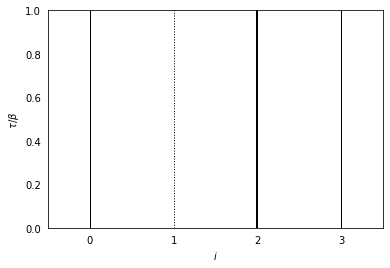

In [280]:
importlib.reload(pimc)
# Simulation parameters
t = 0
U = 1
mu = 1
L = 4
N = 4
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity
eta = 1/np.sqrt(L*beta)

# Canonical or Grand Canonical?
canonical = True # False means Grand Canonical

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
#alpha = [1,1,1,1]
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [ ]:
importlib.reload(pimc)
# Do insert many times on the above configuration
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
mc_steps = int(1E+06)
egs_list = []
n_list = []
occ_list = []

# Counters for acceptance of each move
acc_insert = 0
acc_delete = 0
acc_timeshift = 0
acc_insert_zero = 0
acc_delete_zero = 0
acc_insert_beta = 0
acc_delete_beta = 0
# Counters for proposal of each move
prop_insert = 0
prop_delete = 0
prop_timeshift = 0
prop_insert_zero = 0
prop_delete_zero = 0
prop_insert_beta = 0
prop_delete_beta = 0
for m in range(mc_steps):
    
    # Propose all moves sequentially
    result = pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_insert += 1
        acc_insert += result
        
    result = pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_delete += 1
        acc_delete += result
    
    result = pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
    if result != None:
        prop_timeshift += 1
        acc_timeshift += result
        
    result = pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_insert_zero += 1
        acc_insert_zero += result
        
    result = pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_delete_zero += 1
        acc_delete_zero += result
        
    result = pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_insert_beta += 1
        acc_insert_beta += result
        
    result = pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    if result != None:
        prop_delete_beta += 1
        acc_delete_beta += result
    
    # Calculate observables when there are no worms present
    if m >= 0.25*mc_steps and m%L==0: # Ignore unequilibrated data
        if head_loc == [] and tail_loc == []:
            egs_list.append(pimc.egs_pimc(data_struct,beta,U,mu)) # <E>
            n_list.append(pimc.n_pimc(data_struct,beta)/L) # <n>
            occ_list.append(pimc.n_i_pimc(data_struct,beta))

In [ ]:
pimc.view_worldlines(data_struct,beta,figure_name=None)
head_loc,tail_loc

In [ ]:
# Acceptance ratios
print("-------- Acceptance Ratios --------")
print("          Insert: %.4f%% (%d)"%(100*acc_insert/prop_insert,prop_insert))
print("          Delete: %.4f%% (%d)"%(100*acc_delete/prop_delete,prop_delete))
print("       Timeshift: %.4f%% (%d)"%(100*acc_timeshift/prop_timeshift,prop_timeshift))
print("Insert from zero: %.4f%% (%d)"%(100*acc_insert_zero/prop_insert_zero,prop_insert_zero))
print("Delete from zero: %.4f%% (%d)"%(100*acc_delete_zero/prop_delete_zero,prop_delete_zero))
print("Insert from beta: %.4f%% (%d)"%(100*acc_insert_beta/prop_insert_beta,prop_insert_beta))
print("Delete from beta: %.4f%% (%d)"%(100*acc_delete_beta/prop_delete_beta,prop_delete_beta))

In [ ]:
print("N_check: ",pimc.N_tracker(data_struct,beta))
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Process data

In [274]:
egs = np.mean(egs_list)
n = np.mean(n_list)
occ = np.mean(occ_list,axis=0)
samples = len(egs_list)
print(samples)

1179


In [275]:
importlib.reload(pimc)
print("Samples: %d"%samples)
print("-------- Ground State Energy --------")
print("PIMC: %.8f"%egs)
#print("Exact: %.8f"%pimc.egs_theory(L,U,mu))
print("-------- Average particles per site --------")
print("PIMC: %.8f"%n)
print("-------- Average occupation --------")
print("PIMC:",occ)

Samples: 1179
-------- Ground State Energy --------
PIMC: -0.19847328
-------- Average particles per site --------
PIMC: 1.00000000
-------- Average occupation --------
PIMC: [1.09245123 0.985581   0.98049194 0.94147583]


### Running average as a function of sample number

In [16]:
egs_mean = np.zeros(samples)
egs_total = 0
for i in range(samples):
    egs_total += egs_list[i]
    egs_mean[i] = egs_total/(i+1)

In [ ]:
sample_list = list(range(samples))
plt.plot(range(samples),egs_mean)
#plt.axhline()
plt.ylabel(r'$\langle E \rangle$')
plt.xlabel(r'$\mathrm{sample}$')
plt.savefig('egs_%i_%i_%.4f_%.4f_%.4f_%i.pdf'%(L,N,U,mu,eta,mc_steps))

### Save data

In [10]:
egs_list = np.array(egs_list)
with open("egs_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,egs_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_list = np.array(n_list)
with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
occ_list = np.array(occ_list)
with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,occ_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    
    
    
    

0.4

### Test the total particle number tracker

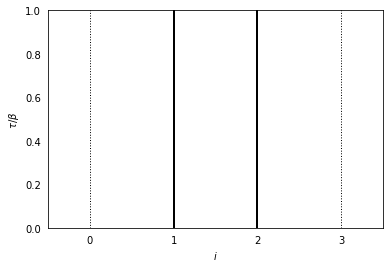

In [4]:
importlib.reload(pimc)
# Simulation parameters
N = 4
L = N   # unit-filling
t = 0
U = 1
n_min = 1
mu = U*(n_min-1/2)
mu = 0

canonical = True # False for Grand Canonical simulation
    
# PIMC parameters
beta = 1
eta = 1
#eta = 1/np.sqrt(L*beta)      # worm end fugacity

# Create unit filling initial configuration
alpha = []
for i in range(L):
    alpha.append(1)
alpha

alpha = [0,2,2,0]

data_struct = pimc.create_data_struct(alpha)
#data_struct[0].append([beta/2,0,(0,0)])
#data_struct[3].append([3*beta/4,0,(3,3)])

head_loc = []
tail_loc = []
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [6]:
N_check = pimc.N_tracker(data_struct,beta)
egs = pimc.egs_pimc(data_struct,beta,U,mu)
N_check

4.0

In [ ]:
# # Determine the menu of moves based on the worm ends present
    
#     # --- Restaurant 0: Configurations with no worm ends ---
#     # Menu 0: No worm ends present
#     if head_loc == [] and tail_loc == []:
#         N_moves = 1
#         p_move = 1/N_moves
#         prop_insert += 1
#         acc_insert += pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
    
#     # --- Restaurant 1: Configurations with only one worm end ---
#     elif (head_loc!=[] and tail_loc==[]) or (head_loc==[] and tail_loc!=[]):
        
#         if head_loc!=[]:
#             x = head_loc[0]
#             k = head_loc[1]
#         else:
#             x = tail_loc[0]
#             k = tail_loc[1]
#         flats = len(data_struct[x])
        
#         if k == 1 or k == flats-1:
#             is_edge = True
#         else:
#             is_edge = False
            
#         if k == 1 and k == flats-1:
#             is_firstlast = True
#         else:
#             is_firstlast = False
        
#         if not(is_firstlast):
#             if k == 1:
#                 is_first = True
#             if k == flats - 1:
#                 is_first = False
        
#         # Menu 1a: Worm end near zero
#         if is_edge and not(is_firstlast) and is_first:
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             elif r==1:
#                 prop_insert_zero += 1
#                 acc_insert_zero += pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==2
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)

#         # Menu 1b: Worm end near beta
#         elif is_edge and not(is_firstlast) and not(is_first):
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             elif r==1:
#                 prop_insert_beta += 1
#                 acc_insert_beta += pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==2
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
                
#         # Menu 1c: Worm end near zero and beta simultaneously
#         elif is_edge and is_firstlast:
#             N_moves = 5
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             elif r==1:
#                 prop_insert_zero += 1
#                 acc_insert_zero += pimc.insert_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             elif r==2:
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             elif r==3:
#                 prop_insert_beta += 1
#                 acc_insert_beta += pimc.insert_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==4
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
                
#         # Menu 1d: Worm end far from either edge
#         else:
#             N_moves = 1
#             p_move = 1/N_moves
#             prop_timeshift +=1
#             acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
              
#     # --- Restaurant 2: Configurations with TWO WORM ENDS on DIFFERENT FLATS ---
#     elif (head_loc!=[] and tail_loc!=[]) and np.abs(head_loc[1]-tail_loc[1]!=1):
        
#         hx,hk = head_loc[0],head_loc[1]
#         tx,tk = tail_loc[0],tail_loc[1]
        
#         h_flats = len(data_struct[hx])
#         t_flats = len(data_struct[tx])
        
#         # Menu 3a: One worm end near zero, one near beta
#         if (hk==1 and tk==t_flats-1) or (hk==h_flats-1 and tk==1):
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             elif r==1:
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==2
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
                
#         # Menu 3b: At least one worm end near zero, none near beta
#         elif hk==1 or tk==1:
#             N_moves = 2
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             else: # r==1
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)   

#         # Menu 3c: At least one worm end near beta, none near zero
#         elif hk==h_flats-1 or tk==t_flats-1:
#             N_moves = 2
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             else: # r==1
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
            
#         # Menu 3d: Neither worm end near edge
#         else:
#             N_moves = 1
#             p_move = 1/N_moves
#             prop_timeshift +=1
#             acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
                
#     # --- Restaurant 3: Configurations with TWO WORM ENDS on SAME FLAT ---
#     else:
        
#         hx,hk = head_loc[0],head_loc[1]
#         tx,tk = tail_loc[0],tail_loc[1]
        
#         h_flats = len(data_struct[hx])
#         t_flats = len(data_struct[tx])
        
#         # Menu 3a: One worm end near zero, one near beta
#         if (hk==1 and tk==t_flats-1) or (hk==h_flats-1 and tk==1):
#             N_moves = 4
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_delete += 1
#                 acc_delete += pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             elif r==1:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             elif r==2:
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==3
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
                
#         # Menu 3b: At least one worm end near zero, none near beta
#         elif hk==1 or tk==1:
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_delete += 1
#                 acc_delete += pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             elif r==1:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             else: # r==2
#                 prop_delete_zero += 1
#                 acc_delete_zero += pimc.delete_gsworm_zero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)   

#         # Menu 3c: At least one worm end near beta, none near zero
#         elif hk==h_flats-1 or tk==t_flats-1:
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_delete += 1
#                 acc_delete += pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             elif r==1:
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
#             else: # r==2
#                 prop_delete_beta += 1
#                 acc_delete_beta += pimc.delete_gsworm_beta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
        
#         # Menu 3d: Neither worm end near edge
#         else:
#             N_moves = 3
#             r = np.random.randint(N_moves)
#             p_move = 1/N_moves
#             if r==0:
#                 prop_delete += 1
#                 acc_delete += pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N)
#             else: # r==1
#                 prop_timeshift +=1
#                 acc_timeshift += pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)